<a href="https://colab.research.google.com/github/leejs209/MesaABM/blob/master/MesaABM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Python 및 행위자 기반 모형을 통한 교내 사회적 거리두기 정책의 효과 분석


##  1.  준비

필요한 패키지 설치, 관련 설정 및 import

In [1]:
!pip install mesa

In [2]:
%matplotlib inline

In [3]:
from mesa import Agent, Model
from mesa.time import RandomActivation
from mesa.space import MultiGrid
from mesa.datacollection import DataCollector
from random import shuffle
from matplotlib import font_manager, rc
import matplotlib.pyplot as plt
import pandas as pd
import datetime
import time
import glob
import os
from __future__ import print_function

In [4]:
# Add Korean font support
import matplotlib as mpl
import matplotlib.pyplot as plt
 
%config InlineBackend.figure_format = 'retina'
 
!apt-get -y install fonts-nanum

import matplotlib.font_manager as fm
plt.rc('font', family='NanumSquare')
fm._rebuild()

Reading package lists... Done
Building dependency tree       
Reading state information... Done
fonts-nanum is already the newest version (20170925-1).
0 upgraded, 0 newly installed, 0 to remove and 12 not upgraded.


In [5]:
from google.colab import drive
drive.mount('/content/drive') 

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


##  2.  모델 구현

####  각 스텝에서 S,E,I,R 상태의 행위자의 수를 제시하는 함수 정의  

In [6]:
def s_count(model):
    cnt = 0
    for agent in model.schedule.agents:
        if agent.status == "S":
            cnt += 1
    return cnt


def i_count(model):
    cnt = 0
    for agent in model.schedule.agents:
        if agent.status == "I":
            cnt += 1
    return cnt


def r_count(model):
    cnt = 0
    for agent in model.schedule.agents:
        if agent.status == "R":
            cnt += 1
    return cnt

def e_count(model):
    cnt = 0
    for agent in model.schedule.agents:
        if agent.status == "E":
            cnt += 1
    return cnt

def affected(model):
    return model.N - s_count(model)

####  Student 및 School Class (모델) 구현

In [7]:
class Student(Agent):
    """ A Student that moves depending on the time, space, and other students"""
    def __init__(self, unique_id, group_no, status, infection_duration, model, dinner):
        super().__init__(unique_id, model)
        self.group_no = group_no
        self.reside_no = group_no
        self.status = status
        self.infected_timeleft = infection_duration
        self.infection_duration = infection_duration
        self.exposed_timeleft = self.model.exposed_duration
        self.dinner = dinner

    def meal_normal(self):
        if len(self.model.order) != 0:
            t = self.model.order[self.unique_id - 1]
        else:
            t = self.unique_id
        k = ((t - 1) // 5) % 46
        if k % 2 == 0:
            xpos = k * 3 / 2 + 1
        else:
            xpos = (k * 3 + 1) / 2
        ypos = (t - 1) % 5 + 31 + 6 * ((t - 1) // 460)
        self.model.grid.move_agent(self, (int(xpos), int(ypos)))

    def meal_distanced(self):
        k = self.unique_id - 1
        layer = k // 230
        t = k % 5
        if t == 0:
            xpos = 3 * (k % 230) // 5 + 1
            ypos = 31 + layer * 6
        elif t == 1:
            xpos = 3 * (k % 230 - 1) / 5 + 1
            ypos = 33 + layer * 6
        elif t == 2:
            xpos = 3 * (k % 230 - 2) / 5 + 1
            ypos = 35 + layer * 6
        elif t == 3:
            xpos = 3 * (k % 230 - 3) / 5 + 2
            ypos = 32 + layer * 6
        else:
            xpos = 3 * (k % 230 - 4) / 5 + 2
            ypos = 34 + layer * 6
        self.model.grid.move_agent(self, (int(xpos), int(ypos)))

    def move_to_group(self, group_no):
        x1 = ((group_no - 1) % 14) * 10 + 1
        x2 = x1 + 8

        y1 = ((group_no - 1) // 14) * 10 + 1
        y2 = y1 + 8

        new_pos = (self.random.randint(x1, x2), self.random.randint(y1, y2))
        self.model.grid.move_agent(self, new_pos)

    def move_within_bound(self, group_no):
        x1 = ((group_no - 1) % 14) * 10 + 1
        x2 = x1 + 8

        y1 = ((group_no - 1) // 14) * 10 + 1
        y2 = y1 + 8

        # if not x1 <= self.pos[0] <= x2 or not y1 <= self.pos[1] <= y2:
        #    print("Agent is told to move in group's bound without being in it first.", x1, self.pos[0], x2, y1, self.pos[1], y2)

        possible_steps = self.model.grid.get_neighborhood(self.pos, moore=True, include_center=False, radius=1)

        bounded_steps = []
        for x in possible_steps:
            if x1 <= x[0] <= x2 and y1 <= x[1] <= y2:
                bounded_steps.append(x)

        if len(bounded_steps) == 0:
            return

        new_pos = self.random.choice(bounded_steps)
        self.model.grid.move_agent(self, new_pos)

    def spread_infection(self, multiplier):
        # Spread infection only when self is Infected or Exposed
        if self.status != "I" and self.status != "E":
            return

        cellmates = self.model.grid.get_cell_list_contents([self.pos])
        if len(cellmates) <= 1:
            return

        if self.status == "I":
            for x in cellmates:
                if x.status == "S" and self.random.random() <= self.model.infection_prob_per_contact * multiplier:
                    x.status = "E"
        else:
            for x in cellmates:
                if x.status == "S" and self.random.random() <= self.model.exposed_infection_prob_per_contact * multiplier:
                    x.status = "E"

    def recovery_countdown(self):
        if self.status == "E":
            if self.exposed_timeleft > 0:
                self.exposed_timeleft -= 1
            else:
                self.status = "I"
                self.exposed_timeleft = self.model.exposed_duration

        if self.status == "I":
            if self.infected_timeleft > 0:
                self.infected_timeleft -= 1
            else:
                self.status = "R"
                self.infected_timeleft = self.infection_duration
                
    def step(self):
        #step_no는 1, 2, ...
        #홀수반 = 1학년, 짝수반 = 2학년
        if self.model.split_opening and (((self.model.step_no - 1) // len(self.model.timetable)) // 5) % 2 == 0: #홀수주
            open_schedule = 23
        elif self.model.split_opening and (((self.model.step_no - 1) // len(self.model.timetable)) // 5) % 2 == 1: #짝수주
            open_schedule = 13
        else:
            open_schedule = 123 #격주등교 안함
        inschool = open_schedule == 123 or (open_schedule == 13 and not self.group_no in range(2,29,2)) or (open_schedule == 23 and not self.group_no in range(1,29,2))
        m = self.model.timetable[(self.model.step_no - 1)% len(self.model.timetable)]

        #격주등교시 미등교 학년 비활성
        if self.model.split_opening and self.group_no in range(2,29,2) and open_schedule == 13:
            self.model.grid.move_agent(self, (139, 60))
        elif self.model.split_opening and self.group_no in range(1,29,2) and open_schedule == 23:
            self.model.grid.move_agent(self, (139, 60))
        #등교하는 경우
        elif inschool:
            if m == 'meal':
                if self.model.meal_distanced == True:
                    self.meal_distanced()
                    self.spread_infection(self.model.restaurant_multiplier)
                else:
                    self.meal_normal()
                    self.spread_infection(self.model.restaurant_multiplier)

            elif m == 'meal_cont':
                self.spread_infection(self.model.restaurant_multiplier)

            elif m == 'recess':
                #교실 간 이동 확률
                if self.random.random() < self.model.visit_prob_per_person:
                    if not open_schedule == 23 and self.group_no in range(1,29,2): # 등교한 1학년
                        self.reside_no = self.random.randrange(1,29,2)
                        self.move_to_group(self.reside_no)
                        self.spread_infection(1)
                    elif not open_schedule == 13 and self.group_no in range(2,29,2): # 등교한 2학년
                        self.reside_no = self.random.randrange(2, 29, 2)
                        self.move_to_group(self.reside_no)
                        self.spread_infection(1)
                    elif self.group_no in range(29,43): # 3학년
                        self.reside_no = self.random.randint(29, 42)
                        self.move_to_group(self.reside_no)
                        self.spread_infection(1)
                    else: #미등교자 무시
                        pass
                else:
                    #이동 안하면 자기 반으로 배치
                    self.reside_no = self.group_no
                    self.move_to_group(self.group_no)
                    self.spread_infection(1)

            elif m == 'recess_cont':
                self.move_within_bound(self.reside_no)
                if inschool:
                    self.spread_infection(1)

            elif m == 'dinner' and self.dinner == True:
                if self.model.meal_distanced == True and inschool:
                    self.meal_distanced()
                    self.spread_infection(self.model.restaurant_multiplier)
                elif inschool:
                    self.meal_normal()
                    self.spread_infection(self.model.restaurant_multiplier)
                else:
                    pass

            elif m == 'dinner' and self.dinner == False:
                self.model.grid.move_agent(self, (139,60))

            elif m == 'dinner_cont':
                if self.dinner == True and inschool:
                    self.spread_infection(self.model.restaurant_multiplier)
        else:
            print("This error shouldn't happen.")
        self.recovery_countdown()

In [8]:
class SchoolModel(Model):
    def __init__(self, N, N_per_group, width, height, initial_num_infected,
                 infection_duration, exposed_duration, infection_prob_per_contact, exposed_infection_prob_per_contact,
                 restaurant_multiplier, visit_prob_per_person,
                 meal_random, meal_distanced, timetable, dinner_percentage, split_opening
                 ):

        super().__init__()
        self.N = N
        self.i_count = 0
        self.e_count = 0
        self.s_count = self.N
        self.r_count = 0
        self.step_no = 0
        self.N_per_group = N_per_group
        self.timetable = timetable
        self.infection_duration = infection_duration * len(self.timetable)
        self.exposed_duration = exposed_duration * len(self.timetable)
        self.infection_prob_per_contact = infection_prob_per_contact
        self.restaurant_multiplier = restaurant_multiplier
        self.visit_prob_per_person = visit_prob_per_person
        self.meal_random = meal_random
        self.meal_distanced = meal_distanced
        self.dinner_percentage = dinner_percentage
        self.split_opening = split_opening
        self.exposed_infection_prob_per_contact = exposed_infection_prob_per_contact

        order = []
        if self.meal_random:
            for i in range(1, self.N + 1):
                order.append(i)
            shuffle(order)

        self.order = order
        # self.grid = ContinuousSpace(width, height, True)
        self.grid = MultiGrid(width, height, False)
        self.schedule = RandomActivation(self)

        if self.split_opening:
            initial_infected = [self.random.randrange(14*25, self.N) for _ in range(initial_num_infected)]
        else:
            initial_infected = [self.random.randrange(0, self.N) for _ in range(initial_num_infected)]

        for t in range(0, self.N):
            # (self, unique_id, group_no, status, infection_duration, model)
            group_no = t // N_per_group + 1

            x1 = ((group_no - 1) % 14) * 10 + 1
            x2 = x1 + 8

            y1 = ((group_no - 1) // 14) * 10 + 1
            y2 = y1 + 8

            a = Student(t + 1, group_no, "S", self.infection_duration, self, False)

            if t in initial_infected:
                a.status = "I"

            if self.random.random() < self.dinner_percentage:
                a.dinner = True

            self.schedule.add(a)

            self.grid.place_agent(a, (self.random.randint(x1, x2), self.random.randint(y1, y2)))

        self.datacollector = DataCollector(
            model_reporters={"Susceptible": s_count, "Infected": i_count, "Recovered": r_count, "Exposed": e_count},
            agent_reporters={}
        )

        self.affected_collector = DataCollector(
            model_reporters={"Affected": affected},
            agent_reporters={}
        )

    def step(self):
        """ Advance the model by one step."""
        self.step_no += 1
        self.i_count = i_count(self)
        self.s_count = s_count(self)
        self.e_count = e_count(self)
        self.r_count = r_count(self)

        self.datacollector.collect(self)
        self.schedule.step()

####  `do_experiment`  함수 구현
목적:  모델 실행 한번 한번의 출력값을 적절한 이름의 csv 파일으로 출력해준다.

In [9]:
timetable_normal = ['recess', 'recess_cont', 'recess', 'recess_cont', 'recess', 'recess_cont', 'recess', 'recess_cont', 'recess', 'recess_cont', 'recess', 'recess_cont', 'meal', 'meal_cont', 'meal_cont', 'recess', 'recess_cont', 'recess_cont', 'recess_cont', 'recess_cont', 'recess_cont', 'recess', 'recess_cont', 'recess', 'recess_cont']
timetable_extra = timetable_normal + ['recess', 'recess_cont', 'recess', 'recess_cont', 'dinner', 'dinner_cont', 'dinner_cont', 'recess', 'recess_cont', 'recess_cont', 'recess_cont', 'recess_cont', 'recess_cont', 'recess_cont']

RESULT_DIR = "/content/drive/My Drive/Colab Notebooks/MesaABM/result/"  # 출력 폴더. "/"로 끝나야 한다.
STUDENT_NO = 1050  # 총 학생 수

def do_experiment(EXPERIMENT_NAME, model):
    """ RESULT_DIR/csv/EXPERIMENT_NAME라는 폴더에 실험 실행 결과의 csv 파일을 저장한다."""

    datetime_string = str(datetime.datetime.now().strftime('%m-%d %H-%M-%S'))
    start = time.time()  # 모델 실행에 걸리는 시간을 측정한다.
    model.step()
    while model.i_count != 0 or model.e_count != 0:  # 감염자 또는 잠복기가 0명이 될 때까지 측정한다.
        model.step()

    result = model.datacollector.get_model_vars_dataframe()

    # csv 파일로 실험 결과를 출력한다.
    if not os.path.exists(RESULT_DIR):
        os.mkdir(RESULT_DIR)
    if not os.path.exists(RESULT_DIR + 'csv'):
        os.mkdir(RESULT_DIR + 'csv')
    if not os.path.exists(RESULT_DIR + 'csv/' + EXPERIMENT_NAME):
        os.mkdir(RESULT_DIR + 'csv/' + EXPERIMENT_NAME)

    result.to_csv(RESULT_DIR + 'csv/' + EXPERIMENT_NAME + '/' + EXPERIMENT_NAME + datetime_string + '.csv')

    # 소요 시간 출력
    end = time.time()
    print(str(end-start) + '초 소요')

#### 결과 해석용 함수 정의
`average_IER`: RESULT_DIR/csv에서 인자로 받은 EXPERIMENT_NAME라는 이름을 가진 폴더의 csv 파일들의 평균을 구하여 RESULT_DIR/average에 저장한다.\
`combine_same_hypothesis()`: 여러번 수행한 실험 결과를 한 그래프에 겹쳐서 그린다.\
`combine_averages()`: 여러 가설들의 그래프를 한 그래프로 합쳐서 그린다.

In [10]:
def average_IER(EXPERIMENT_NAME, DAY_LENGTH):
    """ RESULT_DIR/csv에서 인자로 받은 EXPERIMENT_NAME라는 이름을 가진 폴더의 csv 파일들의 평균을 구하여 RESULT_DIR/average에 저장한다."""

    if not os.path.exists(RESULT_DIR + 'average'):
        os.mkdir(RESULT_DIR + 'average')
    # DAY_LENGTH = 25
    # DAY_LENGTH = 37

    # do_experiment에서 출력한 실험의 결과를 모두 불러온다.
    path = RESULT_DIR + 'csv/' + EXPERIMENT_NAME
    all_files = glob.glob(os.path.join(path, "*.csv"))
    df_from_each_file = [pd.read_csv(f) for f in all_files]

    # 실험 결과 파일 중 step 수가 가장 짧은 값을 구한다.
    cnt = float('inf')
    for x in df_from_each_file:
        a = len(x.Susceptible.index)
        if a < cnt:
            cnt = len(x.Susceptible.index)

    # 불러온 실험들의 각 행에 대해 (전체 인구 - S값)의 평균을 구하고 k 리스트에 추가한다.
    k = []
    for y in range(1, cnt, DAY_LENGTH):
        r = 0
        a = 0
        for t in df_from_each_file:
            r += STUDENT_NO - t.iloc[y, 1]
            a += 1
        r = r / a
        k.append(r)

    # x축을 경과 시간으로, y축을 (전체 - S)의 인구수의 값으로 하여 Dataframe을 출력한다.
    final = pd.DataFrame(data=k, index=range(cnt // DAY_LENGTH + 1))
    final.to_csv(RESULT_DIR + 'average/' + EXPERIMENT_NAME + '_infected_average.csv')


In [11]:
def combine_same_hypothesis(EXPERIMENT_NAME):
    path = RESULT_DIR + 'csv/' + EXPERIMENT_NAME
    all_files = glob.glob(os.path.join(path, "*.csv"))

    df_from_each_file = [pd.read_csv(f) for f in all_files]

    # 첫번쨰 파일을 탬플릿으로
    final = df_from_each_file[0]
    final.drop(["Infected", 'Recovered', 'Exposed'], axis=1, inplace=True)
    final.rename(columns={'Susceptible': os.path.basename(list(all_files)[0])}, inplace=True)

    # 여러 실험을 한 dataframe으로 합치기
    for t in range(1, len(df_from_each_file)):
        x = df_from_each_file[t]
        x.drop(["Infected", 'Recovered', 'Exposed'], axis=1, inplace=True)
        x.rename(columns={'Susceptible': os.path.basename(list(all_files)[t])}, inplace=True)
        
        t += 1
        final = pd.merge(final, x, how='outer')

    # 필요없는 step column 지우기
    final.drop(['Unnamed: 0'], axis=1, inplace=True)

    if not os.path.exists(RESULT_DIR + 'total'):
        os.mkdir(RESULT_DIR + 'total')
    final.to_csv(RESULT_DIR + 'total/' + EXPERIMENT_NAME + '_EIR_combined.csv')
    final.plot(legend=None)
    plt.title(EXPERIMENT_NAME, fontsize=16)
    plt.xlim(0, 2000)
    plt.savefig(RESULT_DIR + 'total/' + EXPERIMENT_NAME + '_EIR_combined_xlim.png', bbox_inches='tight', dpi=300)
    plt.show()
    plt.close()

In [12]:
def combine_averages():
    """ 실험 결과를 평균처리 한 파일을 하나의 dataframe으로 합치고 그래프를 출력한다. """
    # average 폴더의 csv 파일을 모두 불러온다
    path = RESULT_DIR + 'average'
    all_files = glob.glob(os.path.join(path, "*.csv"))
    df_from_each_file = [pd.read_csv(f) for f in all_files]

    # average 폴더에서 불러온 첫 파일을 템플릿으로 삼고, csv 파일 이름을 column 이름으로 한다.
    final = df_from_each_file[0]
    final.rename(columns={'0': os.path.basename(list(all_files)[0])}, inplace=True)

    # average 폴더의 나머지 파일에서 IER 합친 값을 불러온 후 final Dataframe에 추가한다.
    for t in range(1, len(df_from_each_file)):
        x = df_from_each_file[t]
        x.rename(columns={'0': os.path.basename(list(all_files)[t])}, inplace=True)
        t += 1
        final = pd.merge(final, x, how='outer')

    # 마무리 작업으로 step column을 제거한다.
    final.drop(['Unnamed: 0'], axis=1, inplace=True)

    # 최종적으로 합친 값을 출력한다.
    final.to_csv(RESULT_DIR + 'average/infected_average.csv')

    # 그래프로 출력한다.
    final.plot()
    plt.title('실험 결과', fontsize=16)
    plt.savefig(RESULT_DIR + 'average/infected_average.png', bbox_inches='tight', dpi=300)
    plt.show()
    plt.close()

##  3.  모델 실행

###  가.  마스크의 효과 확인

In [13]:
no_of_experiment = 50

####  1)  β값이 0.1일 때

In [14]:
for t in range(no_of_experiment):
  print(str(t+1) + '번째 실험')
  do_experiment('0.1', SchoolModel(N=STUDENT_NO, N_per_group=25, width=140, height=61, initial_num_infected=1,
                        infection_duration=7, exposed_duration=5,
                        infection_prob_per_contact=0.1, exposed_infection_prob_per_contact=0.05,
                        restaurant_multiplier=3, visit_prob_per_person=0.1,
                        meal_random=True, meal_distanced=False, dinner_percentage=0.3,
                        timetable=timetable_extra, split_opening=False))

1번째 실험
23.61902117729187초 소요
2번째 실험
24.459943056106567초 소요
3번째 실험
23.103723764419556초 소요
4번째 실험
23.92903208732605초 소요
5번째 실험
23.67623209953308초 소요
6번째 실험
24.771446228027344초 소요
7번째 실험
25.42145848274231초 소요
8번째 실험
25.377554178237915초 소요
9번째 실험
24.01735758781433초 소요
10번째 실험
23.837393760681152초 소요
11번째 실험
24.49238920211792초 소요
12번째 실험
25.753268480300903초 소요
13번째 실험
23.960964679718018초 소요
14번째 실험
21.294313192367554초 소요
15번째 실험
24.288509368896484초 소요
16번째 실험
23.7545108795166초 소요
17번째 실험
24.643996477127075초 소요
18번째 실험
23.78985571861267초 소요
19번째 실험
24.68081307411194초 소요
20번째 실험
23.31393337249756초 소요
21번째 실험
23.309540510177612초 소요
22번째 실험
25.208109855651855초 소요
23번째 실험
25.062233209609985초 소요
24번째 실험
22.958409786224365초 소요
25번째 실험
30.94005537033081초 소요
26번째 실험
23.14700198173523초 소요
27번째 실험
24.38556432723999초 소요
28번째 실험
22.420634746551514초 소요
29번째 실험
24.488887548446655초 소요
30번째 실험
22.631993770599365초 소요
31번째 실험
24.11752700805664초 소요
32번째 실험
25.5191752910614초 소요
33번째 실험
21.117623329162598초 소요
34번

#### 2) β값이 0.2일 때

(아래 실험의 대조군과 동일)

#### 2) β값이 0.3일 때

In [15]:
for t in range(no_of_experiment):
  print(str(t+1) + '번째 실험')
  do_experiment('0.3', SchoolModel(N=STUDENT_NO, N_per_group=25, width=140, height=61, initial_num_infected=1,
                        infection_duration=7, exposed_duration=5,
                        infection_prob_per_contact=0.3, exposed_infection_prob_per_contact=0.05,
                        restaurant_multiplier=3, visit_prob_per_person=0.1,
                        meal_random=True, meal_distanced=False, dinner_percentage=0.3,
                        timetable=timetable_extra, split_opening=False))

1번째 실험
21.62132239341736초 소요
2번째 실험
20.6730477809906초 소요
3번째 실험
21.926279067993164초 소요
4번째 실험
21.888787746429443초 소요
5번째 실험
21.23172354698181초 소요
6번째 실험
20.132176637649536초 소요
7번째 실험
21.316404104232788초 소요
8번째 실험
21.20332980155945초 소요
9번째 실험
20.35413956642151초 소요
10번째 실험
19.80417799949646초 소요
11번째 실험
21.698813676834106초 소요
12번째 실험
21.814735889434814초 소요
13번째 실험
21.103438138961792초 소요
14번째 실험
21.519123792648315초 소요
15번째 실험
20.627671480178833초 소요
16번째 실험
21.26030445098877초 소요
17번째 실험
22.04190468788147초 소요
18번째 실험
21.654785871505737초 소요
19번째 실험
21.821590900421143초 소요
20번째 실험
21.272469758987427초 소요
21번째 실험
20.80941081047058초 소요
22번째 실험
21.95116686820984초 소요
23번째 실험
20.967779636383057초 소요
24번째 실험
21.52955389022827초 소요
25번째 실험
21.887614965438843초 소요
26번째 실험
20.872034788131714초 소요
27번째 실험
21.46983289718628초 소요
28번째 실험
21.04293131828308초 소요
29번째 실험
23.61906099319458초 소요
30번째 실험
22.17433452606201초 소요
31번째 실험


KeyboardInterrupt: ignored

###  나.  거리두기 정책 비교

In [ ]:
no_of_experiment = 50

#### 1) 대조군

In [ ]:
for t in range(no_of_experiment):
    print(str(t+1) + "번쨰 실험")
    do_experiment('대조군', SchoolModel(N=STUDENT_NO, N_per_group=25, width=140, height=61, initial_num_infected=1,
                        infection_duration=7, exposed_duration=5,
                        infection_prob_per_contact=0.2, exposed_infection_prob_per_contact=0.05,
                        restaurant_multiplier=3, visit_prob_per_person=0.1,
                        meal_random=True, meal_distanced=False, dinner_percentage=0.3,
                        timetable=timetable_extra, split_opening=False))

#### 2) 1,2학년 교차 등교를 한다면?
가설 1번

In [ ]:
for t in range(no_of_experiment):
    print(str(t+1) + "번쨰 실험")
    do_experiment('1번', SchoolModel(N=STUDENT_NO, N_per_group=25, width=140, height=61, initial_num_infected=1,
                        infection_duration=7, exposed_duration=5,
                        infection_prob_per_contact=0.2, exposed_infection_prob_per_contact=0.05,
                        restaurant_multiplier=3, visit_prob_per_person=0.1,
                        meal_random=True, meal_distanced=False, dinner_percentage=0.3,
                        timetable=timetable_extra, split_opening=True))

#### 3) 보충과 야자를 하지 않는다면?
가설 2번

In [ ]:
for t in range(no_of_experiment):
    print(str(t+1) + "번쨰 실험")
    do_experiment('2번', SchoolModel(N=STUDENT_NO, N_per_group=25, width=140, height=61, initial_num_infected=1,
                        infection_duration=7, exposed_duration=5,
                        infection_prob_per_contact=0.2, exposed_infection_prob_per_contact=0.05,
                        restaurant_multiplier=3, visit_prob_per_person=0.1,
                        meal_random=True, meal_distanced=False, dinner_percentage=0.3,
                        timetable=timetable_normal, split_opening=False))

#### 4) 교실 간 이동을 금지한다면?
가설 3번

In [ ]:
for t in range(no_of_experiment):
    print(str(t+1) + "번쨰 실험")
    do_experiment('3번', SchoolModel(N=STUDENT_NO, N_per_group=25, width=140, height=61, initial_num_infected=1,
                        infection_duration=7, exposed_duration=5,
                        infection_prob_per_contact=0.2, exposed_infection_prob_per_contact=0.05,
                        restaurant_multiplier=3, visit_prob_per_person=0,
                        meal_random=True, meal_distanced=False, dinner_percentage=0.3,
                        timetable=timetable_extra, split_opening=False))

#### 5) 급식 순서를 반별로 먹는다면?
가설 4번

In [ ]:
for t in range(no_of_experiment):
    print(str(t+1) + "번쨰 실험")
    do_experiment('4번', SchoolModel(N=STUDENT_NO, N_per_group=25, width=140, height=61, initial_num_infected=1,
                        infection_duration=7, exposed_duration=5,
                        infection_prob_per_contact=0.2, exposed_infection_prob_per_contact=0.05,
                        restaurant_multiplier=3, visit_prob_per_person=0.1,
                        meal_random=False, meal_distanced=False, dinner_percentage=0.3,
                        timetable=timetable_extra, split_opening=False))

###  4.  결과 분석

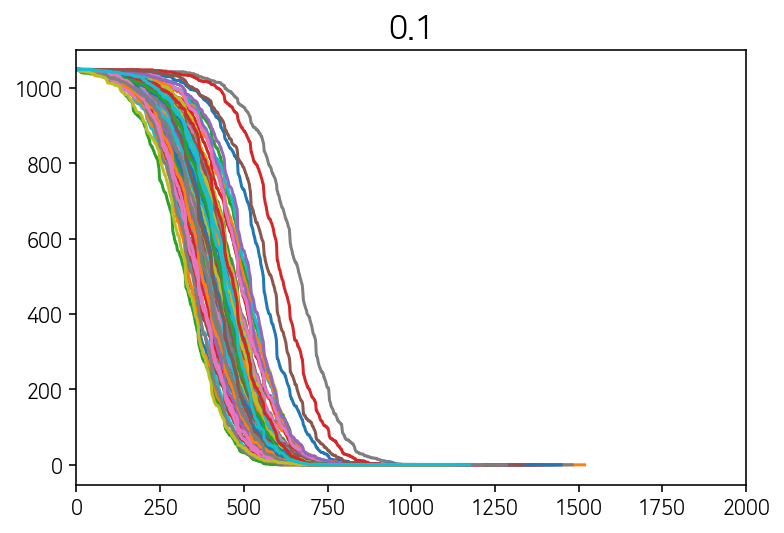

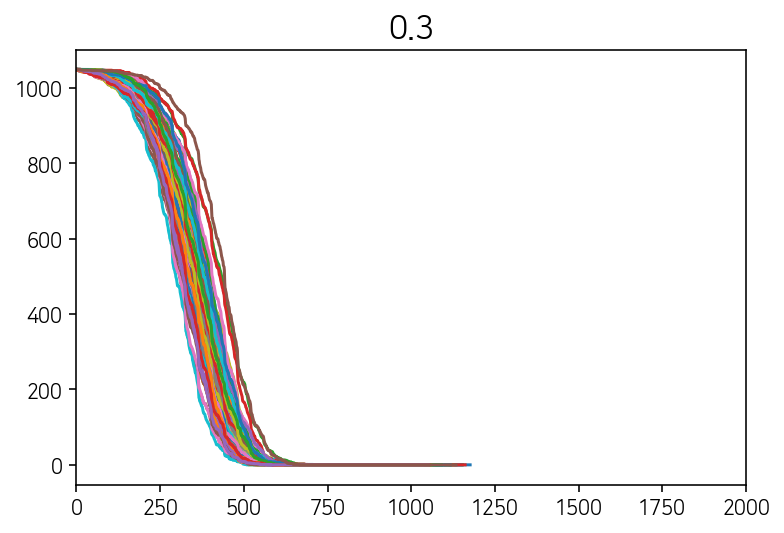

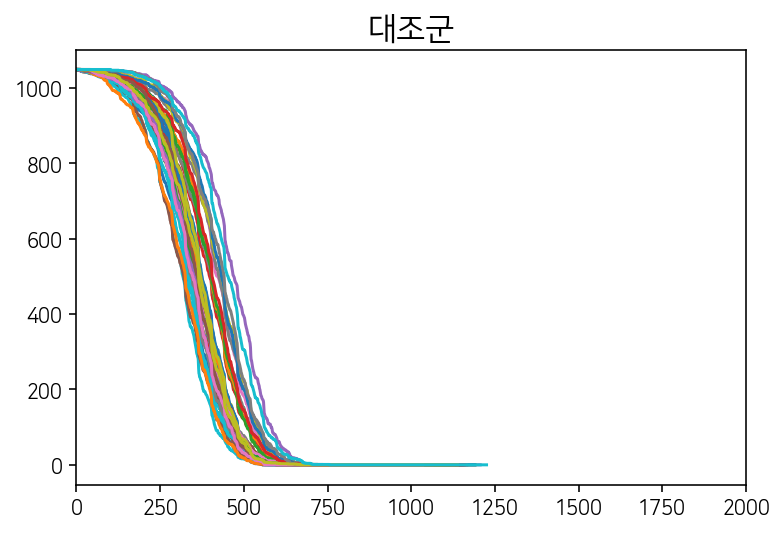

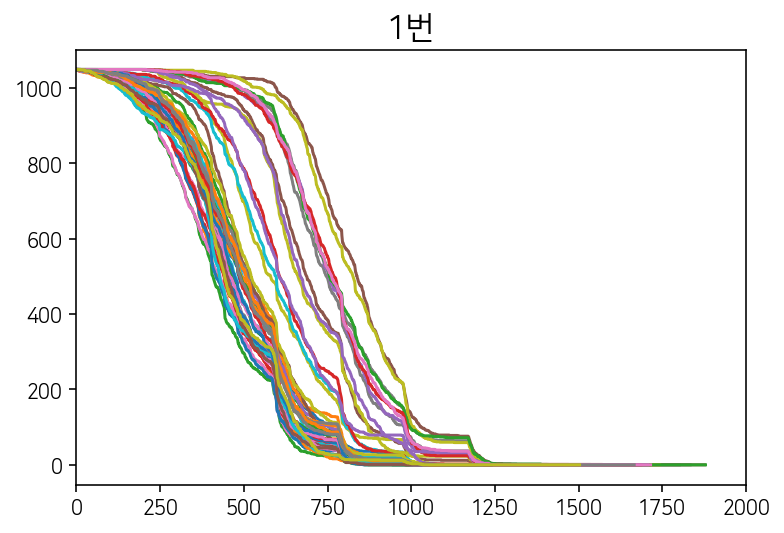

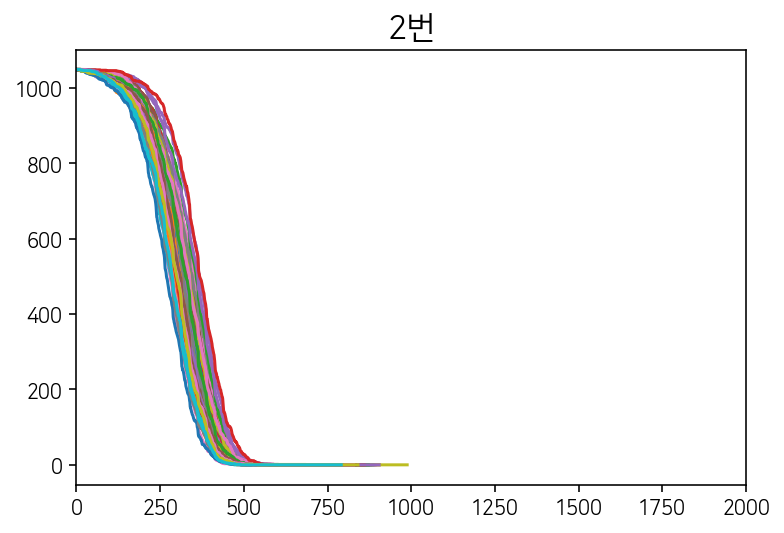

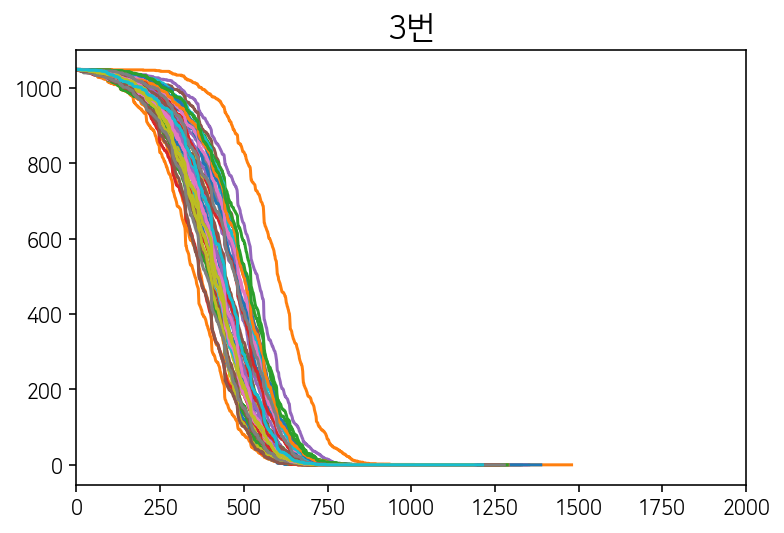

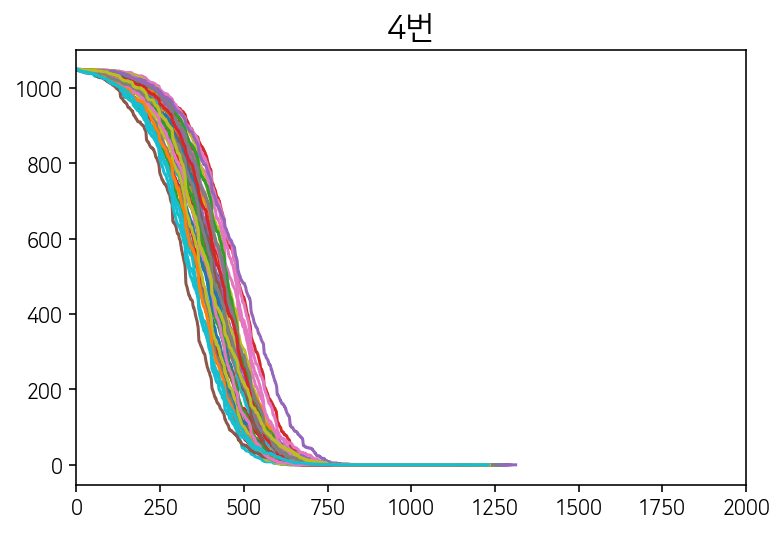

In [13]:
combine_same_hypothesis('0.1')
combine_same_hypothesis('0.3')
combine_same_hypothesis('대조군')
combine_same_hypothesis('1번')
combine_same_hypothesis('2번')
combine_same_hypothesis('3번')
combine_same_hypothesis('4번')

In [14]:
average_IER('0.1', 37)  #  37은 하루가 37스텝임을 의미
average_IER('0.3', 37)  #  37은 하루가 37스텝임을 의미
average_IER('대조군', 37)  #  37은 하루가 37스텝임을 의미
average_IER('1번', 37)  #  37은 하루가 37스텝임을 의미
average_IER('2번', 25)  #  25은 하루가 25스텝임을 의미
average_IER('3번', 37)  #  37은 하루가 37스텝임을 의미
average_IER('4번', 37)  #  37은 하루가 37스텝임을 의미

/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 4355 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 4450 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 4364 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 4457 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 4352 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 4462 missing from current font.
  font.set_text(s

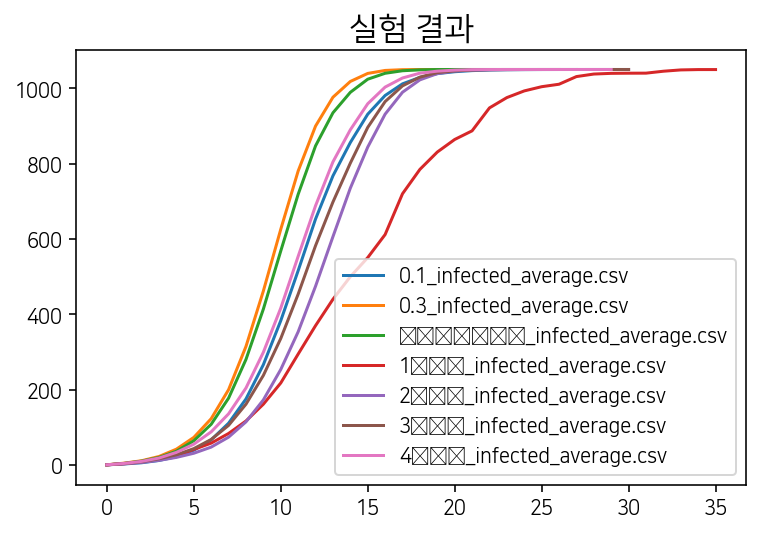

In [15]:
combine_averages()